---
# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Aug 16 17:34:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# @title Install dependencies
!pip install opencv-python==4.1.2.30 --quiet
!pip install numba --quiet

In [ ]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

# Our import functions
import glob
import matplotlib.image as mpimg
from pathlib import Path
from sklearn.metrics import precision_score, f1_score


---
# Intro to segmentation + denoising

## Data loading

In [ ]:
# # Define working directory
# working_dir = os.getcwd()        
# data_path = os.path.join(working_dir,'data')

# # Extract names of image files (as strings)
# original_names = []
# label_names = {'L':[],'R':[]}

# for root, dirs, files in os.walk(data_path):
#      for file in files:
#         with open(os.path.join(root, file), "r") as auto:
#             if 'label' in root:
#                 if '_L' in file:
#                     label_names['L'].append(os.path.join(root, file))
#                 if '_R' in file:
#                     label_names['R'].append(os.path.join(root, file)) 
                    
#             elif 'original' in root:
#                 original_names.append(os.path.join(root, file))

# original_names.sort(key=lambda f: int("".join(filter(str.isdigit, f))))
# label_names['L'].sort(key=lambda f: int("".join(filter(str.isdigit, f))))
# label_names['R'].sort(key=lambda f: int("".join(filter(str.isdigit, f))))

In [ ]:
# # Load images from image names
# original_images = []
# label_images = []
# filtered_image_names = []

# def binarize(img,threshold=100):
#     # make all pixels < threshold black
#     binarized = img > threshold
#     return binarized

# def get_label_name(image_name,hemisphere):
#     id_s = Path(image_name).name.split('_')[-1]
#     s = Path(image_name).name.split('_')[0:5]
#     if hemisphere == 'L':
#         s = '_'.join(s) + '_L_' + id_s
#     elif hemisphere == 'R':
#         s = '_'.join(s) + '_R_' + id_s
#     return s

# blank = 0

# for image_name in original_names:
#     img = mpimg.imread(image_name)
#     if np.max(img) > 10:        
#         name_R = get_label_name(image_name,'R')
#         name_L = get_label_name(image_name,'L')

#         path_L = list(filter(lambda x: name_L in x, label_names['L']))
#         path_R = list(filter(lambda x: name_R in x, label_names['R']))
        
#         if len(path_R) != 0: # if both R and L label images exist          
#             img_L = mpimg.imread(path_L[0])
#             img_R = mpimg.imread(path_R[0])            
#             label_image = binarize(img_L[:,:,0]) + binarize(img_R[:,:,0])
                        
#             # Crop images and remove any that don't contain hippocampus            
#             if np.max(label_image) == 1:
#                 label_images.append(label_image[18:215,:])
#                 original_images.append(img[18:215,:,0])
#                 filtered_image_names.append(image_name)
#                 blank = 1

#             elif blank == 1:
#                 label_images.append(label_image[18:215,:])
#                 original_images.append(img[18:215,:,0])
#                 filtered_image_names.append(image_name)  
#                 blank = 0
                                
# original_images = np.array(original_images)
# label_images = np.array(label_images)

In [ ]:
data_path = '/content/drive/MyDrive/NMA_DL_project/data_npy_format'
model_path = '/content/drive/MyDrive/NMA_DL_project/models'

original_images=np.load(os.path.join(data_path,'images.npy'))
label_images=np.load(os.path.join(data_path,'labels.npy'))

In [ ]:
# for Lin's PC
# original_images = np.load('original_images.npz',allow_pickle=True)['original_images']
# label_images = np.load('label_images.npz',allow_pickle=True)['label_images']




In [ ]:
# for Guanghan's PC
# original_images=np.load('C:\\Users\\Guanghan-WallerLab\\Documents\\Neuromatch project\\images_with_blanks.npy')
# label_images=np.load('C:\\Users\\Guanghan-WallerLab\\Documents\\Neuromatch project\\labels_with_blanks.npy')

In [ ]:
original_images.shape, label_images.shape

((3997, 197, 197), (3997, 197, 197))

In [ ]:
# Split dataset into train and test set
from sklearn.model_selection import train_test_split

label_images_abs = np.max(label_images,axis=(1,2))

images_train, images_test, label_train, label_test = train_test_split(original_images, label_images, 
                                                    test_size=0.2, random_state=42, stratify=label_images_abs)

label_train_abs = np.max(label_train,axis=(1,2))
images_train, images_val, label_train, label_val = train_test_split(images_train, label_train, 
                                                    test_size=0.2, random_state=42, stratify=label_train_abs)

images_train = np.expand_dims(images_train, axis=1)
images_val = np.expand_dims(images_val, axis=1)
images_test = np.expand_dims(images_test, axis=1)

label_train = np.expand_dims(label_train, axis=1)
label_val = np.expand_dims(label_val, axis=1)
label_test = np.expand_dims(label_test, axis=1)


In [ ]:
# Normalize images (zero mean, std=1)
mean_train = np.mean(images_train)
std_train = np.std(images_train)

images_train = (images_train - mean_train) / std_train
images_val = (images_val - mean_train) / std_train
images_test = (images_test - mean_train) / std_train

In [ ]:
# Load images into pytorch DataLoader

In [ ]:
# Train U-Net segmentation network

# Class imbalance problem:
# Since there are many images with no hippocampus, we want to count these images less towards the loss

# When calculating the loss on each forward pass:
# LOSS = 0.85 * mean(loss(x_with, y_with)) + 0.15 * mean(loss(x_without, y_without))

In [ ]:
def convbatchrelu(in_channels, out_channels, sz):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                 out_channels,
                                                 kernel_size))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size))

  def forward(self, x, y):
    #print(x.shape, y.shape)
    x = self.conv[0](x)
    x = self.conv[1](x + y)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      if n > 0:
        x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 1 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

In [ ]:
def resize(X,xy=(200, 200)):
    reshape_im = []
    for n in range(X.shape[0]):
        reshape_im.append(cv2.resize(X[n,0],xy))
    reshape_im = np.array(np.expand_dims(reshape_im,axis=1))
    return reshape_im


def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(200, 200),
                             do_flip=True): # change to (200,200), which is /2**3 
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1],xy[0]),
                                  flags=cv2.INTER_NEAREST)

  return imgi, lbl, scale

In [ ]:
# set random seed 
import random
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [ ]:
kernel_size = 3
nbase = [1, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

In [ ]:

from datetime import datetime

# train the network
# parameters related to training the network
batch_size = 8 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
### you will want to increase n_epochs!
n_epochs = 50  # number of times to cycle through all the data during training
learning_rate = 0.1 # initial learning rate
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 # how much to use previous gradient direction
n_epochs_per_save = 25 # how often to save the network
val_frac = 0.05 # what fraction of data to use for validation
augmentation = False


# where to save the network
# make sure to clean these out every now and then, as you will run out of space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

n_train = images_train.shape[0]
n_val = images_val.shape[0]

# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)

# set learning rate schedule
LR = np.linspace(0, learning_rate, 10)
if n_epochs > 250:
    LR = np.append(LR, learning_rate*np.ones(n_epochs-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, learning_rate * np.ones(max(0, n_epochs - 10)))

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan
val_losses = np.zeros(n_epochs)
val_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through entire training data set nepochs times
for epoch in range(n_epochs):

  epoch_loss = 0
  val_loss=0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img') as pbar:
    # loop through each batch in the training data
    net.train() # put in train mode (affects batchnorm)
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))
      if augmentation == True:
        imgs, lbls, _ = random_rotate_and_resize(images_train[inds],label_train[inds].astype(int),xy = (200,200))
      else: 
        imgs = resize(images_train[inds],xy = (200,200))
        lbls = resize(label_train[inds].astype(float),xy = (200,200)).astype(int)

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)
      imgs = imgs.to(dtype=torch.float32)
      lbls = lbls.to(dtype=torch.int64)

      # compute the loss
      y = net(imgs)
      loss = criterion(y, lbls[:, 0])
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])

    net.eval()  

    for ibatch in np.arange(0,n_val,batch_size):
      inds = np.arange(ibatch, min(n_val, ibatch+batch_size))
      if augmentation == True:
        imgs_val, lbls_val, _ = random_rotate_and_resize(images_val[inds],label_val[inds].astype(int),xy = (200,200))
      else:
        imgs_val = resize(images_val[inds],xy = (200,200))
        lbls_val = resize(label_val[inds].astype(float),xy = (200,200)).astype(int)
      imgs_val = torch.from_numpy(imgs_val).to(device=device)
      lbls_val = torch.from_numpy(lbls_val).to(device=device)
      imgs_val = imgs_val.to(dtype=torch.float32)
      lbls_val = lbls_val.to(dtype=torch.int64)  
      output = net(imgs_val)
      loss = criterion(output,lbls_val[:, 0])
      val_loss+=loss.item()
      pbar.set_postfix(**{'val (batch)': loss.item()})

  # Setting up mean loss: n_val/batch_size= total number of batches
    epoch_losses[epoch] = epoch_loss/(n_train/batch_size)
    val_losses[epoch] = val_loss/(n_val/batch_size)
    
    
    pbar.set_postfix(**{'loss (epoch)': epoch_loss,'Val (epoch)': val_loss})  #.update('loss (epoch) = %f'%epoch_loss)

  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
if augmentation:
    fname = 'unet_epoch_'+str(epoch+1)+'_augmentation.pth'
    np.save('augmentation_epoch_loss',epoch_losses)
    np.save('augmentation_val_losses',val_losses)
else:
    fname = 'unet_epoch_'+str(epoch+1)+'_no_augmentation.pth'
    np.save('no_augmentation_epoch_loss',epoch_losses)
    np.save('no_augmentation_val_losses',val_losses)    
net.save_model(fname)

Epoch 1/50:  39%|█████████████████▌                           | 1032/2643 [02:43<04:15,  6.30img/s, loss (batch)=0.822]


KeyboardInterrupt: 

(0.0, 3.0)

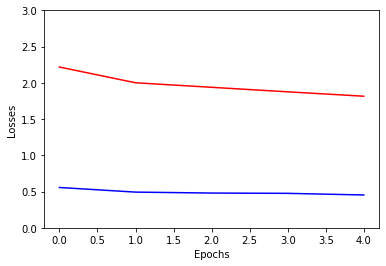

In [ ]:
def plot_loss(epoch_losses, val_losses):
    plt.plot(epoch_losses,'r')
    plt.plot(val_losses,'b')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.ylim([0,np.max([epoch_losses, val_losses])])

In [ ]:
# Every epoch: compute validation loss & store it

# plot the training loss and the validation loss over epochs


In [ ]:
# load saved model from google drive
net.load_model(os.path.join(model_path,'unet_epoch26.pth'))

In [ ]:
# load saved model from local PC
# net = Unet(nbase, nout, kernel_size) # build a new model
net.load_state_dict(torch.load('unet_epoch50.pth',map_location=torch.device('cpu'))) # assign the saved parameters to the new model
net.eval()

Unet(
  (downsample): downsample(
    (down): Sequential(
      (conv_down_0): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv_1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
      )
      (conv_down_1): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv_1): Sequent

In [ ]:
net.load_model('unet_epoch50.pth')

## Model architecture (u-net)

A u-net is commonly used for biological image segmentation because its shape allows for local and global features to be combined to create highly-precise segmentations.

A u-net is shaped like an autoencoder, it has:
1. a standard convolutional network with downsampling, like one used for imagenet
2. upsampling layers that ultimately return an image at the same size as the input image
In addition to these downsampling and upsampling blocks, it has skip connections from the downsampling blocks TO the upsampling blocks, which allows it to propagate more precise local information to the later layers.

adapted from [cellpose/resnet_torch.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/resnet_torch.py).


### Define the network

### Train the network

Here we've implemented code to train the network.

Note we probably should be evaluating test performance throughout training -- implement that yourself.

### Test performance

Let's see how the network performs on a test image.

In [ ]:
# @markdown Padding code for test images

def pad_image_ND(img0, div=16, extra=1):
  """ pad image for test-time so that its dimensions are a multiple of 16 (2D or 3D)

  Parameters
  -------------
  img0: ND-array
      image of size [nchan (x Lz) x Ly x Lx]
  div: int (optional, default 16)

  Returns
  --------------
  I: ND-array
      padded image
  slices: tuple, int
      range of pixels in I corresponding to img0
  """
  Lpad = int(div * np.ceil(img0.shape[-2] / div) - img0.shape[-2])
  xpad1 = extra * div//2 + Lpad//2
  xpad2 = extra * div//2 + Lpad - Lpad//2
  Lpad = int(div * np.ceil(img0.shape[-1] / div) - img0.shape[-1])
  ypad1 = extra * div//2 + Lpad//2
  ypad2 = extra * div//2 + Lpad - Lpad//2

  if img0.ndim > 3:
    pads = np.array([[0, 0], [0, 0], [xpad1, xpad2], [ypad1, ypad2]])
  else:
    pads = np.array([[0, 0], [xpad1, xpad2], [ypad1, ypad2]])

  I = np.pad(img0, pads, mode='constant')

  Ly, Lx = img0.shape[-2:]
  ysub = np.arange(xpad1, xpad1 + Ly)
  xsub = np.arange(ypad1, ypad1 + Lx)
  slc = [slice(0, img0.shape[n] + 1) for n in range(img0.ndim)]
  slc[-3] = slice(0, img0.shape[-3] + 1)
  slc[-2] = slice(ysub[0], ysub[-1] + 1)
  slc[-1] = slice(xsub[0], xsub[-1] + 1)
  slc = tuple(slc)

  return I, slc

In [ ]:
# torch.cuda.empty_cache()
!nvidia-smi

Mon Aug 16 16:23:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    72W / 149W |    472MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# compute results on test images
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))
# image = images_train[0]
n = 5;
image = resize(images_test)
label = resize(label_test.astype(float)).astype(int)
net.eval()
img_torch = torch.tensor(image).to(device)
img_torch = img_torch.to(torch.float32)
#img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
print(img_torch.shape)
out = net(img_torch[0:n])

torch.Size([800, 1, 200, 200])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#  calculate seg for all images, TO DO

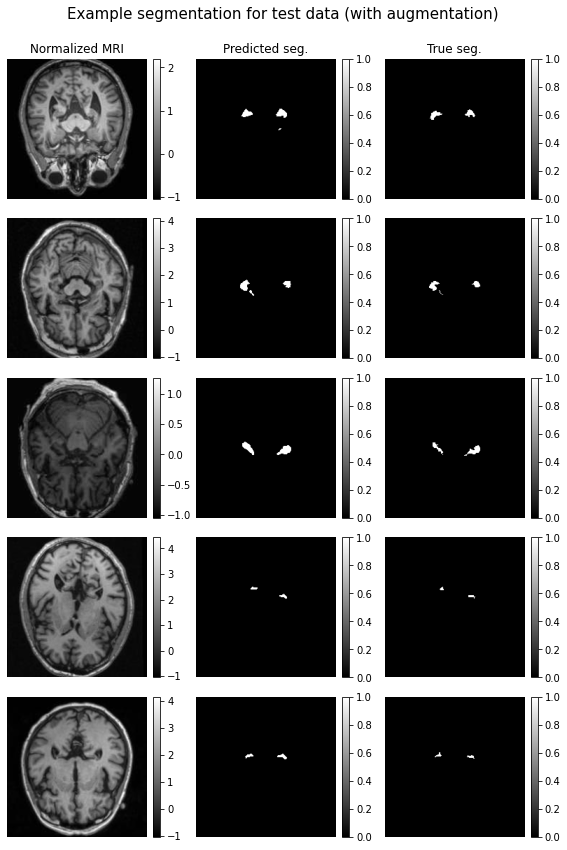

In [ ]:
from matplotlib import gridspec

color_code = '#0699C8'#'#e377c2'
color_code = '#006666'#'#e377c2'
legend_pos = 'lower left'
fig = plt.figure(figsize=(8,12))
nrows=5;
ncols=3;
gs = gridspec.GridSpec(nrows, ncols,figure=fig)
# gs.update(wspace=0.6, hspace=0.3) # set the spacing between axes. 

for rowIndx in range(nrows):
    prediction = np.array(out[rowIndx].detach().cpu())
    seg = np.argmax(prediction,axis=0)
    for cIndx in range(ncols):
        ax = fig.add_subplot(gs[rowIndx, cIndx]) 
        ax.axis('off')
        if cIndx == 0:
            plt.imshow(image[rowIndx][0], cmap = 'gray')
            plt.colorbar(fraction=0.046, pad=0.04)
            if rowIndx == 0:
                plt.title('Normalized MRI')
        if cIndx == 1: 
            plt.imshow(seg, cmap = 'gray')
            plt.colorbar(fraction=0.046, pad=0.04)
            if rowIndx == 0:
                plt.title('Predicted seg.')
        if cIndx == 2: 
            plt.imshow(label[rowIndx][0], cmap = 'gray')
            plt.colorbar(fraction=0.046, pad=0.04)
            if rowIndx == 0:
                plt.title('True seg.')   
plt.rc('font', family='sans-serif', serif='Helvetica')
plt.suptitle('Example segmentation for test data (with augmentation)', fontsize = 15)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()
# plt.savefig('Example_with_augmentation.png', dpi=600,bbox_inches='tight')
# plt.savefig('Example_with_augmentation.svg', dpi=600,bbox_inches='tight')

In [ ]:
print(label[0].shape, seg.shape)

(1, 200, 200) (200, 200)


In [ ]:
# Test network performance & plot performance metrics
# https://scikit-learn.org/stable/modules/classes.html?highlight=metric#module-sklearn.metrics

def compute_metrics(all_labels, all_segs): 
    """
    Computes precision and f1 score 
    """
    p = []
    f = []
    n = all_labels.shape[0]
    print(n)
    for imgIndx in range(n):
        p.append( precision_score(all_labels[imgIndx].flatten(), all_segs[imgIndx].flatten()) )
        f.append( f1_score(all_labels[imgIndx].flatten(), all_segs[imgIndx].flatten()) )
    return p, f

In [ ]:
# compute results on test images
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))
# image = images_train[0]
n = 2;
image = resize(images_test)
label = resize(label_test.astype(float)).astype(int)
net.eval()
img_torch = torch.tensor(image).to(device)
img_torch = img_torch.to(torch.float32)
#img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
# print(img_torch.shape)
out = net(img_torch[0:n])
prediction = np.array(out.detach().cpu())
# seg = np.argmax(prediction,axis=0)

In [ ]:
seg = np.argmax(prediction,axis=0)
seg.shape,label_test[0:2].shape

((2, 200, 200), (2, 1, 197, 197))

In [ ]:
label_test_resized = resize(label_test.astype(float)).astype(int)
label_test_resized = label_test_resized[:,0,:,:]

print(label_test_resized.shape)

(800, 200, 200)


In [ ]:
print(label_test_resized[0:2].shape, seg.shape)
p,f = compute_metrics(label_test_resized[0:2], seg)
print(p,f)

(2, 200, 200) (2, 200, 200)
2
[0.009193907875185736, 0.01008020810752222] [0.018220299990797828, 0.019959223092606504]


In [ ]:
### Implement cyleGAN

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2340, done.
remote: Total 2340 (delta 0), reused 0 (delta 0), pack-reused 2340
Receiving objects: 100% (2340/2340), 8.09 MiB | 10.41 MiB/s, done.
Resolving deltas: 100% (1501/1501), done.


In [ ]:
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 676 kB 5.0 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=1f0c99de7118a725cf7379371008a7bd6638ca7208a1ada6b37422f17f676851
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=0d68f9eff71cdf25fa6b8bc26df29d2ce512eadad9c154b3461e3dac8e556d9c
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built visdom torchfile


In [ ]:
# Download the dataset
!bash ./datasets/download_cyclegan_dataset.sh horse2zebra

Specified [horse2zebra]
for details.

--2021-08-16 16:01:05--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  1.66MB/s    in 43s     

2021-08-16 16:01:49 (2.58 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/

(256, 256, 3)


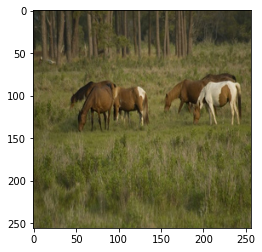

In [ ]:
# print(os.getcwd())
img = plt.imread('datasets/horse2zebra/trainA/n02381460_1856.jpg')
print(img.shape)
plt.imshow(img)

In [ ]:
# Download the pretrained network
!bash ./scripts/download_cyclegan_model.sh horse2zebra

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [horse2zebra]
for details.

--2021-08-16 16:07:19--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/horse2zebra.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/horse2zebra_pretrained/latest_net_G.pth’

./checkpoints/horse 100%[===================>]  43.46M  3.30MB/s    in 12s     

2021-08-16 16:07:31 (3.65 MB/s) - ‘./checkpoints/horse2zebra_pretrained/latest_net_G.pth’ saved [45575747/45575747]

